# 1. import

In [1]:
from copy import deepcopy
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, Sampler, DataLoader, Subset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler

# 커스텀 파이토치 데이터셋 / 모델 + 유틸 함수 import
from data_utils import *
from feature_eng import *

torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# 2. 데이터 정보 + 상수 선언

In [2]:
aws_df = combine_df('./TRAIN_AWS/', './META/awsmap.csv')
pm_df = combine_df('./TRAIN/', './META/pmmap.csv')

## 2.1 기상 관측소 (AWS) 데이터

In [3]:
aws_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1051920 entries, 0 to 35063
Data columns (total 10 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   연도         1051920 non-null  int64  
 1   일시         1051920 non-null  object 
 2   지점         1051920 non-null  object 
 3   기온(°C)     1032972 non-null  float64
 4   풍향(deg)    1032972 non-null  float64
 5   풍속(m/s)    1032972 non-null  float64
 6   강수량(mm)    1032972 non-null  float64
 7   습도(%)      1032972 non-null  float64
 8   Latitude   1051920 non-null  float64
 9   Longitude  1051920 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 88.3+ MB


## 2.2 미세먼지 관측소 (PM) 데이터

In [4]:
pm_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 596088 entries, 0 to 35063
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   연도         596088 non-null  int64  
 1   일시         596088 non-null  object 
 2   측정소        596088 non-null  object 
 3   PM2.5      580546 non-null  float64
 4   Latitude   596088 non-null  float64
 5   Longitude  596088 non-null  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 31.8+ MB


## 2. 3 상수 선언

In [5]:
num_aws = 30           # 총 기상 관측소 개수
num_pm = 17            # 총 미세먼지 관측소 개수
num_aws_features = 7   # 기상 특성 개수
num_pm_features = 8    # 기상 특성 + 미세먼지 특성 개수
num_timestamps = len(aws_df.groupby(['연도', '일시']).groups)

aws_dir = './TRAIN_AWS/'

# 3. AWS 예측 모델

## 3.1 전처리

In [6]:
positions = pd.concat([aws_df[['Latitude', 'Longitude']], pm_df[['Latitude', 'Longitude']]])
lat_scaler = MinMaxScaler()
lon_scaler = MinMaxScaler()
lat_scaler.fit(positions['Latitude'].values.reshape(-1, 1))
lon_scaler.fit(positions['Longitude'].values.reshape(-1, 1))

MinMaxScaler()

In [7]:
# 위도 경도 정보 불러오기 + 위치 명 정수화 하기
region_encoder = OrdinalEncoder()
meta_df = pd.read_csv('./META/awsmap.csv')
meta_df['지점'] = meta_df['Location'].copy()
meta_df['Location'] = region_encoder.fit_transform(meta_df['지점'].to_frame())
meta_df = meta_df.iloc[:, :-2].sort_values(by='Location')
meta_df = pd.DataFrame(meta_df, index=meta_df['Location'], columns=['Latitude', 'Longitude'])

In [8]:
# 정수화된 지점 아이디와 지점 이름 매핑
regions = list(region_encoder.inverse_transform(np.array(range(30)).reshape(-1, 1)).flatten())
id_to_region = dict(zip(range(30), regions))
regions_to_id = dict(zip(regions, range(30)))

## 3.2 데이터 numpy array로 적제 후 PyTorch 데이터셋 생성하기

In [9]:
data = np.zeros((num_timestamps, num_aws, num_aws_features), float)
data[:, :, :] = np.nan

for i in range(30):
    aws_df = pd.read_csv(aws_dir + id_to_region[i] + '.csv')
    features = aws_df.values[:,3:]
    lat = lat_scaler.transform(meta_df.iloc[i, 0].reshape(-1, 1))
    long = lon_scaler.transform(meta_df.iloc[i, 1].reshape(-1, 1))
    data[:, i, :-2] = features
    data[:, i, -2:] = np.array([lat, long]).flatten()

In [10]:
# 훈련셋 검증셋 나누기
dataset = AWSTrainDataset(data, num_aws=num_aws, time_size=10)
train_idx, valid_idx = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)
trainset, validset = Subset(dataset, train_idx), Subset(dataset, valid_idx)

## 3.3 AWS 모델 훈련

In [11]:
# 하이퍼 파라미터
num_lstm_out = 5
hidden_size = 20
time_size = 10
batch_size = 12
patience = 2
epochs = 50
steps_per_epoch = len(trainset) // batch_size // 10
valid_steps = len(validset) // batch_size // 10

# 데이터로더
trainloader = DataLoader(trainset, batch_size=batch_size, sampler=NonNullSampler(trainset))
validloader = DataLoader(validset, batch_size=batch_size, sampler=NonNullSampler(validset))
train_iter = iter(trainloader)
valid_iter = iter(validloader)

# 모델 생성 
aws_model = FeatureSeqNet(num_aws=num_aws, num_features=num_aws_features, time_size=time_size, hidden_size=hidden_size, num_lstm_out=num_lstm_out)
aws_model.to(float)

# 옵티마이저, 스켸줄러, 손실함수 객체 생성
optimizer = optim.Adagrad(aws_model.parameters(), lr=0.00125, lr_decay=0.0001)
loss_fn = nn.MSELoss()

# 훈련 결과 저장용
metrics = {'train':[], 'valid':[]}

In [12]:
# 훈련 루프
min_val = np.inf
best_params = None
for epoch in range(1, epochs + 1):
    aws_model.train()
    train_loss = 0
    for step in tqdm(range(steps_per_epoch), desc=f'Train epoch {epoch} ', ncols=100):
        inputs, targets = next(train_iter)
        output = aws_model(inputs, targets)
        output = output.view(-1)
        targets = targets.view(-1)
        loss = loss_fn(output, targets)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(aws_model.parameters(), 1)
        optimizer.step()
        train_loss += loss.item()
    train_loss /= steps_per_epoch
    metrics['train'].append(train_loss)

    aws_model.eval()
    val_loss = 0
    for step in tqdm(range(valid_steps), desc=f'Validation epoch {epoch} ', ncols=100):
        inputs, targets = next(valid_iter)
        output = aws_model(inputs, targets)
        output = output.view(-1)
        targets = targets.view(-1)
        loss = loss_fn(output, targets)
        val_loss += loss.item()

    val_loss /= valid_steps
    metrics['valid'].append(val_loss)

    if val_loss < min_val:
        min_val = val_loss
        best_params = deepcopy(aws_model.state_dict())

    print(f'Metrics: Train Loss: {train_loss}, Valid Loss: {val_loss}')

Validation epoch 1 : 100%|█████████████████████████████████████| 1752/1752 [00:09<00:00, 181.50it/s]


Metrics: Train Loss: 0.025639055033215216, Valid Loss: 0.021694008635412813


Validation epoch 2 : 100%|█████████████████████████████████████| 1752/1752 [00:12<00:00, 138.17it/s]


Metrics: Train Loss: 0.02058482146396599, Valid Loss: 0.019898252286546042


Validation epoch 3 : 100%|█████████████████████████████████████| 1752/1752 [00:11<00:00, 148.13it/s]


Metrics: Train Loss: 0.019638714581550715, Valid Loss: 0.019362829416375665


Validation epoch 4 : 100%|█████████████████████████████████████| 1752/1752 [00:11<00:00, 149.37it/s]


Metrics: Train Loss: 0.019263854559629374, Valid Loss: 0.019274512062783043


Validation epoch 5 : 100%|█████████████████████████████████████| 1752/1752 [00:11<00:00, 152.06it/s]


Metrics: Train Loss: 0.019480293317234675, Valid Loss: 0.0191556498545063


Validation epoch 6 : 100%|█████████████████████████████████████| 1752/1752 [00:11<00:00, 152.22it/s]


Metrics: Train Loss: 0.01900085687189312, Valid Loss: 0.01886541594340642


Validation epoch 7 : 100%|█████████████████████████████████████| 1752/1752 [00:11<00:00, 153.26it/s]


Metrics: Train Loss: 0.018833139062776394, Valid Loss: 0.01881876163664371


Validation epoch 8 : 100%|█████████████████████████████████████| 1752/1752 [00:11<00:00, 150.77it/s]


Metrics: Train Loss: 0.01873911012104395, Valid Loss: 0.01858146030857045


Validation epoch 9 : 100%|█████████████████████████████████████| 1752/1752 [00:11<00:00, 149.81it/s]


Metrics: Train Loss: 0.01860000131328874, Valid Loss: 0.01856708608490867


Validation epoch 10 : 100%|████████████████████████████████████| 1752/1752 [00:11<00:00, 147.37it/s]


Metrics: Train Loss: 0.018533493465826893, Valid Loss: 0.01846384078026623


Validation epoch 11 : 100%|████████████████████████████████████| 1752/1752 [00:11<00:00, 151.63it/s]


Metrics: Train Loss: 0.018527399979123203, Valid Loss: 0.018256237794430138


Validation epoch 12 : 100%|████████████████████████████████████| 1752/1752 [00:11<00:00, 155.78it/s]


Metrics: Train Loss: 0.018405996830759178, Valid Loss: 0.01832784419065535


Validation epoch 13 : 100%|████████████████████████████████████| 1752/1752 [00:11<00:00, 155.59it/s]


Metrics: Train Loss: 0.018359330809773883, Valid Loss: 0.018329313650941058


Validation epoch 14 : 100%|████████████████████████████████████| 1752/1752 [00:11<00:00, 153.05it/s]


Metrics: Train Loss: 0.01827755904060477, Valid Loss: 0.018481712589014324


Validation epoch 15 : 100%|████████████████████████████████████| 1752/1752 [00:11<00:00, 153.96it/s]


Metrics: Train Loss: 0.018292110716471598, Valid Loss: 0.018337601811403998


Validation epoch 16 : 100%|████████████████████████████████████| 1752/1752 [00:11<00:00, 156.90it/s]


Metrics: Train Loss: 0.018262236326305505, Valid Loss: 0.018253569478622406


Validation epoch 17 : 100%|████████████████████████████████████| 1752/1752 [00:11<00:00, 152.56it/s]


Metrics: Train Loss: 0.018196925507707636, Valid Loss: 0.018282055964577486


Validation epoch 18 : 100%|████████████████████████████████████| 1752/1752 [00:11<00:00, 156.84it/s]


Metrics: Train Loss: 0.018135303542436462, Valid Loss: 0.018101273230912703


Validation epoch 19 : 100%|████████████████████████████████████| 1752/1752 [00:11<00:00, 153.47it/s]


Metrics: Train Loss: 0.01817152040887151, Valid Loss: 0.01826031708534698


Validation epoch 20 : 100%|████████████████████████████████████| 1752/1752 [00:11<00:00, 152.31it/s]


Metrics: Train Loss: 0.018136852619924423, Valid Loss: 0.018105106966422896


Validation epoch 21 : 100%|████████████████████████████████████| 1752/1752 [00:11<00:00, 150.80it/s]


Metrics: Train Loss: 0.018045372265344008, Valid Loss: 0.018011000720868562


Validation epoch 22 : 100%|████████████████████████████████████| 1752/1752 [00:11<00:00, 152.94it/s]


Metrics: Train Loss: 0.01813537855396627, Valid Loss: 0.018281047842101834


Validation epoch 23 : 100%|████████████████████████████████████| 1752/1752 [00:11<00:00, 153.91it/s]


Metrics: Train Loss: 0.01812686846762959, Valid Loss: 0.01806933055296173


Validation epoch 24 : 100%|████████████████████████████████████| 1752/1752 [00:11<00:00, 151.62it/s]


Metrics: Train Loss: 0.018079229677713967, Valid Loss: 0.018066633840674265


Validation epoch 25 : 100%|████████████████████████████████████| 1752/1752 [00:10<00:00, 168.50it/s]


Metrics: Train Loss: 0.018095566067428646, Valid Loss: 0.018102830267948296


Validation epoch 26 : 100%|████████████████████████████████████| 1752/1752 [00:10<00:00, 169.57it/s]


Metrics: Train Loss: 0.01815310742695911, Valid Loss: 0.018266019614236493


Validation epoch 27 : 100%|████████████████████████████████████| 1752/1752 [00:10<00:00, 164.61it/s]


Metrics: Train Loss: 0.018210828946410667, Valid Loss: 0.01826599809512855


Validation epoch 28 : 100%|████████████████████████████████████| 1752/1752 [00:10<00:00, 166.02it/s]


Metrics: Train Loss: 0.01826724712775314, Valid Loss: 0.018379072345071797


Validation epoch 29 : 100%|████████████████████████████████████| 1752/1752 [00:10<00:00, 172.39it/s]


Metrics: Train Loss: 0.018320681284015802, Valid Loss: 0.01827126280447153


Validation epoch 30 : 100%|████████████████████████████████████| 1752/1752 [00:10<00:00, 174.92it/s]


Metrics: Train Loss: 0.018134048452457096, Valid Loss: 0.018179005908154515


Validation epoch 31 : 100%|████████████████████████████████████| 1752/1752 [00:09<00:00, 177.99it/s]


Metrics: Train Loss: 0.018104341020141086, Valid Loss: 0.018126453789197767


Validation epoch 32 : 100%|████████████████████████████████████| 1752/1752 [00:10<00:00, 168.43it/s]


Metrics: Train Loss: 0.01812605447047501, Valid Loss: 0.01800958679369945


Validation epoch 33 : 100%|████████████████████████████████████| 1752/1752 [00:10<00:00, 173.85it/s]


Metrics: Train Loss: 0.0181720137128044, Valid Loss: 0.018156992446483153


Validation epoch 34 : 100%|████████████████████████████████████| 1752/1752 [00:09<00:00, 178.21it/s]


Metrics: Train Loss: 0.01817829314419991, Valid Loss: 0.01810614286865475


Validation epoch 35 : 100%|████████████████████████████████████| 1752/1752 [00:10<00:00, 172.08it/s]


Metrics: Train Loss: 0.018139245789759367, Valid Loss: 0.0180755809527532


Validation epoch 36 : 100%|████████████████████████████████████| 1752/1752 [00:10<00:00, 174.86it/s]


Metrics: Train Loss: 0.01811219286346246, Valid Loss: 0.01822907652560996


Validation epoch 37 : 100%|████████████████████████████████████| 1752/1752 [00:10<00:00, 171.62it/s]


Metrics: Train Loss: 0.018343805235383023, Valid Loss: 0.018211064103785292


Validation epoch 38 : 100%|████████████████████████████████████| 1752/1752 [00:09<00:00, 176.40it/s]


Metrics: Train Loss: 0.018405570827367365, Valid Loss: 0.018169514269259786


Validation epoch 39 : 100%|████████████████████████████████████| 1752/1752 [00:09<00:00, 178.89it/s]


Metrics: Train Loss: 0.01824738619586165, Valid Loss: 0.018266707734202185


Validation epoch 40 : 100%|████████████████████████████████████| 1752/1752 [00:10<00:00, 171.57it/s]


Metrics: Train Loss: 0.018302658012654235, Valid Loss: 0.01797579082962059


Validation epoch 41 : 100%|████████████████████████████████████| 1752/1752 [00:10<00:00, 170.88it/s]


Metrics: Train Loss: 0.018118088426889094, Valid Loss: 0.01815607444208412


Validation epoch 42 : 100%|████████████████████████████████████| 1752/1752 [00:09<00:00, 175.54it/s]


Metrics: Train Loss: 0.0181933110505179, Valid Loss: 0.01812399144705104


Validation epoch 43 : 100%|████████████████████████████████████| 1752/1752 [00:09<00:00, 177.23it/s]


Metrics: Train Loss: 0.0182644474724085, Valid Loss: 0.01829521496200011


Validation epoch 44 : 100%|████████████████████████████████████| 1752/1752 [00:09<00:00, 178.58it/s]


Metrics: Train Loss: 0.0181531695550421, Valid Loss: 0.01807878179550882


Validation epoch 45 : 100%|████████████████████████████████████| 1752/1752 [00:10<00:00, 171.77it/s]


Metrics: Train Loss: 0.018172264813124592, Valid Loss: 0.018190015775059052


Validation epoch 46 : 100%|████████████████████████████████████| 1752/1752 [00:10<00:00, 173.08it/s]


Metrics: Train Loss: 0.018223751082557093, Valid Loss: 0.018044522758234392


Validation epoch 47 : 100%|████████████████████████████████████| 1752/1752 [00:10<00:00, 173.17it/s]


Metrics: Train Loss: 0.018155442782329494, Valid Loss: 0.018048284215488326


Validation epoch 48 : 100%|████████████████████████████████████| 1752/1752 [00:10<00:00, 175.17it/s]


Metrics: Train Loss: 0.018274647139705464, Valid Loss: 0.018216050187878127


Validation epoch 49 : 100%|████████████████████████████████████| 1752/1752 [00:10<00:00, 174.59it/s]


Metrics: Train Loss: 0.018363473867726483, Valid Loss: 0.018538429543815613


Validation epoch 50 : 100%|████████████████████████████████████| 1752/1752 [00:10<00:00, 172.25it/s]

Metrics: Train Loss: 0.018456019815444976, Valid Loss: 0.018406979620323713


## 3.4 AWS 모델 훈련 시각화

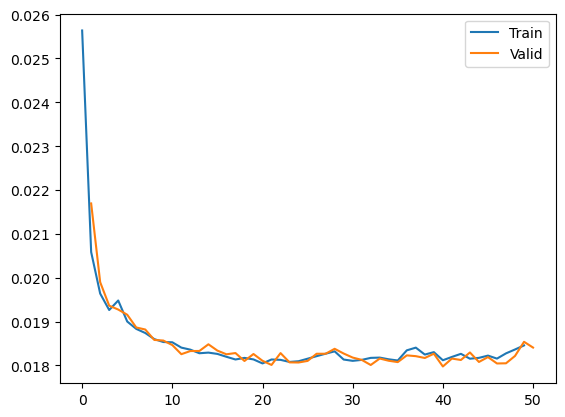

In [13]:
aws_model.load_state_dict(best_params)
train_metrics = metrics['train']
val_metrics = metrics['valid']
plt.plot(range(len(train_metrics)), train_metrics, label='Train')
plt.plot(range(1, len(val_metrics) + 1), val_metrics, label='Valid')
plt.legend()
plt.show()

## 3.5 AWS 결측치 예측

In [14]:
# 시간 (index)과 관측소 (column)별로 측정값이 있는지 없는지 계산하여 DataFrame 형식으로 리턴
def null_time_intervals(root_dir, metadata_path, regions_to_id):
    dfs = []
    meta_df = pd.read_csv(metadata_path)
    for i in range(meta_df.shape[0]):
        csv_path = meta_df.iloc[i]['Location'] + '.csv'
        measure_df = pd.read_csv(root_dir + csv_path)
        null_datapoints = measure_df.isnull().sum(axis=1) > 0
        dfs.append(null_datapoints)
    result = pd.DataFrame()
    for i in range(meta_df.shape[0]):
        result[regions_to_id[meta_df.iloc[i]['Location']]] = dfs[i]
    return pd.DataFrame(result, columns=list(range(num_aws)))

# 결측값들의 (time_idx, aws_idx)의 리스트 만들기
null_times = null_time_intervals('./TRAIN_AWS/', './META/awsmap.csv', regions_to_id)
null_list = []
for time_idx in range(num_timestamps):
    for aws_idx in range(num_aws):
        if null_times.iloc[time_idx, aws_idx]:
            null_list.append((time_idx, aws_idx))

In [15]:
# 결측치 채우기
aws_model.eval()
spatial_enc = aws_model.spatial_encoder
seq_enc = aws_model.sequential_encoder
decoder = aws_model.decoder

data = dataset.data
for time_idx, aws_idx in null_list:
    inputs = torch.Tensor(dataset.get(time_idx, aws_idx))
    spatial_x = spatial_enc(inputs.unsqueeze(0).double())
    cnn_out = seq_enc(spatial_x).reshape(1, 1, -1)
    output, _ = decoder.lstm(cnn_out.repeat((1,1,2)).double())
    output = decoder.affine(torch.concat([cnn_out, output], dim=2).double()).flatten()
    if np.isnan(output.detach().numpy()).sum() > 0:
        raise Exception()
    data[time_idx, aws_idx, :-2] = output.detach().numpy()

## 3.6 AWS 모델 이용하여 PM 관측소의 기상정보 예측

In [16]:
# pm
pm_encoder = OrdinalEncoder()
pm_meta_df = pd.read_csv('./META/pmmap.csv')
pm_meta_df['측정소'] = pm_meta_df['Location'].copy()
pm_meta_df['Location'] = pm_encoder.fit_transform(pm_meta_df['측정소'].to_frame())
pm_meta_df = pm_meta_df.iloc[:, :-2].sort_values(by='Location')
pm_meta_df = pd.DataFrame(pm_meta_df, index=pm_meta_df['Location'], columns=['Latitude', 'Longitude'])

ids = np.arange(17).reshape(-1, 1)
pms = pm_encoder.inverse_transform(ids).flatten()
pm_to_id = dict(zip(pms, ids.flatten()))
id_to_pm = dict(zip(ids.flatten(), pms))

In [18]:
pm_data = np.zeros((num_timestamps, 17, 7))
for time_idx in tqdm(range(10, num_timestamps), ncols=100):
    for pm_idx in range(17):
        lat, lon = list(pm_meta_df.iloc[pm_idx])
        pm_pos = np.array([lat_scaler.transform([[lat]]), lon_scaler.transform([[lon]])])
        inputs = torch.Tensor(dataset.get(time_idx, aws_idx))
        spatial_x = spatial_enc(inputs.unsqueeze(0).double())
        cnn_out = seq_enc(spatial_x).reshape(1, 1, -1)
        output, _ = decoder.lstm(cnn_out.repeat((1,1,2)).double())
        output = decoder.affine(torch.concat([cnn_out, output], dim=2).double()).flatten()
        if np.isnan(output.detach().numpy()).sum() > 0:
            raise Exception()
        pm_data[time_idx, pm_idx, :-2] = output.detach().numpy()
        pm_data[time_idx, pm_idx, -2:] = pm_pos.flatten()

100%|█████████████████████████████████████████████████████████| 35054/35054 [15:50<00:00, 36.86it/s]


# 4. PM 예측 모델

## 4.1 PM 데이터 전처리

In [19]:
# 0번째 특성 PM2.5 추가
data = np.zeros((pm_data.shape[0], pm_data.shape[1], pm_data.shape[2] + 1))
data[:, :, 1:] = pm_data[:, :, :]
data[:10, :, 3] = np.nan
data[:, :, 0] = np.nan

for i in range(num_pm):
    df = pd.read_csv(f'./TRAIN/{id_to_pm[i]}.csv')
    for time_idx in range(data.shape[0]):
        data[time_idx, i, 0] = df.iloc[time_idx]['PM2.5']

In [20]:
pm_meta_df = pd.read_csv('./META/pmmap.csv')
pm_meta_df['측정소'] = pm_meta_df['Location'].copy()
pm_meta_df['Location'] = pm_encoder.transform(pm_meta_df['측정소'].to_frame())
pm_meta_df = pm_meta_df.iloc[:, :-2].sort_values(by='Location')
pm_meta_df = pd.DataFrame(pm_meta_df, index=pm_meta_df['Location'], columns=['Latitude', 'Longitude'])

## 4.2 PyTorch 데이터셋 생성하기

In [21]:
dataset = PMTrainDataset(data, num_aws=num_pm, time_size=time_size)
train_idx, valid_idx = train_test_split(range(len(dataset)), test_size=0.2, random_state=12345)
trainset, validset = Subset(dataset, train_idx), Subset(dataset, valid_idx)
trainloader = DataLoader(trainset, batch_size=batch_size, sampler=NonNullSampler(trainset))
validloader = DataLoader(validset, batch_size=batch_size, sampler=NonNullSampler(validset))

## 4.3 PM 모델 훈련

In [22]:
# 하이퍼파라미터
num_lstm_out = 6
lr = 0.01
patience = 2
epochs = 50
steps_per_epoch = len(trainset) // batch_size // 10
valid_steps = len(validset) // batch_size // 10

# 모델 생성
pm_model = FeatureSeqNet(num_aws=num_pm, num_features=num_pm_features, time_size=time_size, hidden_size=hidden_size, num_lstm_out=num_lstm_out)
pm_model.to(float)

# 옵티마이저, 스켸줄러, 손실함수 생성
optimizer = optim.Adagrad(pm_model.parameters(), lr=0.01, lr_decay=0.001)
loss_fn = nn.L1Loss()
train_iter = iter(trainloader)
valid_iter = iter(validloader)

# 훈련 결과 저장용
metrics = {'train':[], 'valid':[], 'pm mae':[]}

In [23]:
min_val = np.inf
best_params = None

# 훈련 루프
for epoch in range(1, epochs + 1):
    pm_model.train()
    train_loss = 0
    for step in tqdm(range(steps_per_epoch), desc=f'Train epoch {epoch} ', ncols=100):
        inputs, targets = next(train_iter)
        output = pm_model(inputs, targets)
        output = output.view(-1)
        targets = targets.view(-1)
        loss = loss_fn(output, targets)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(pm_model.parameters(), 1)
        optimizer.step()
        train_loss += loss.item()
    train_loss /= steps_per_epoch
    metrics['train'].append(train_loss)

    pm_model.eval()
    val_loss = 0
    val_mae = 0
    for step in tqdm(range(valid_steps), desc=f'Validation epoch {epoch} ', ncols=100):
        inputs, targets = next(valid_iter)
        output = pm_model(inputs, targets)
        pm_out = output[:, :, 0].view(-1)
        pm_target = targets[:, :, 0].view(-1)
        output = output.view(-1)
        targets = targets.view(-1)
        loss = loss_fn(output, targets)
        val_loss += loss.item()
        val_mae += loss_fn(pm_out, pm_target).item()

    val_loss /= valid_steps
    val_mae /= valid_steps
    metrics['valid'].append(val_loss)
    metrics['pm mae'].append(val_mae)
    
    if val_loss < min_val:
        min_val = val_loss
        best_params = deepcopy(pm_model.state_dict())
    
    print(f'Metrics: Train Loss: {train_loss}, Valid Loss: {val_loss}, Valid PM MAE: {val_mae}')

Validation epoch 1 : 100%|███████████████████████████████████████| 992/992 [00:05<00:00, 189.46it/s]


Metrics: Train Loss: 0.03129017908869164, Valid Loss: 0.026656369320026546, Valid PM MAE: 0.025667447676955227


Validation epoch 2 : 100%|███████████████████████████████████████| 992/992 [00:05<00:00, 185.81it/s]


Metrics: Train Loss: 0.02615802393030755, Valid Loss: 0.02557198323863488, Valid PM MAE: 0.0244888385718494


Validation epoch 3 : 100%|███████████████████████████████████████| 992/992 [00:05<00:00, 182.37it/s]


Metrics: Train Loss: 0.025549435462013645, Valid Loss: 0.025349573793144717, Valid PM MAE: 0.023830274318371834


Validation epoch 4 : 100%|███████████████████████████████████████| 992/992 [00:05<00:00, 179.55it/s]


Metrics: Train Loss: 0.025290933408964926, Valid Loss: 0.02519610567681464, Valid PM MAE: 0.023470915738425132


Validation epoch 5 : 100%|███████████████████████████████████████| 992/992 [00:06<00:00, 160.26it/s]


Metrics: Train Loss: 0.02513367066192151, Valid Loss: 0.02496821794157428, Valid PM MAE: 0.023546745159109754


Validation epoch 6 : 100%|███████████████████████████████████████| 992/992 [00:06<00:00, 158.28it/s]


Metrics: Train Loss: 0.025024332605823374, Valid Loss: 0.02482223753833114, Valid PM MAE: 0.023045898754321174


Validation epoch 7 : 100%|███████████████████████████████████████| 992/992 [00:06<00:00, 157.56it/s]


Metrics: Train Loss: 0.024880863436029212, Valid Loss: 0.02488243699244763, Valid PM MAE: 0.02314648221356423


Validation epoch 8 : 100%|███████████████████████████████████████| 992/992 [00:06<00:00, 146.71it/s]


Metrics: Train Loss: 0.02492620351783109, Valid Loss: 0.024708678311471718, Valid PM MAE: 0.023292676999915517


Validation epoch 9 : 100%|███████████████████████████████████████| 992/992 [00:06<00:00, 159.47it/s]


Metrics: Train Loss: 0.02479633606830267, Valid Loss: 0.024725847827701448, Valid PM MAE: 0.023235911089595253


Validation epoch 10 : 100%|██████████████████████████████████████| 992/992 [00:06<00:00, 150.60it/s]


Metrics: Train Loss: 0.02470140461722732, Valid Loss: 0.024636734634427053, Valid PM MAE: 0.02294872043904199


Validation epoch 11 : 100%|██████████████████████████████████████| 992/992 [00:06<00:00, 156.23it/s]


Metrics: Train Loss: 0.024709752087244803, Valid Loss: 0.024724793322589134, Valid PM MAE: 0.022877552824166144


Validation epoch 12 : 100%|██████████████████████████████████████| 992/992 [00:06<00:00, 159.56it/s]


Metrics: Train Loss: 0.024692132062271218, Valid Loss: 0.024628415671277, Valid PM MAE: 0.023006453029350647


Validation epoch 13 : 100%|██████████████████████████████████████| 992/992 [00:06<00:00, 156.66it/s]


Metrics: Train Loss: 0.024616843629129637, Valid Loss: 0.024588057687530404, Valid PM MAE: 0.022832390813125002


Validation epoch 14 : 100%|██████████████████████████████████████| 992/992 [00:06<00:00, 154.56it/s]


Metrics: Train Loss: 0.02455985880828495, Valid Loss: 0.02460854308337988, Valid PM MAE: 0.022848940313553768


Validation epoch 15 : 100%|██████████████████████████████████████| 992/992 [00:06<00:00, 156.51it/s]


Metrics: Train Loss: 0.02461998363099305, Valid Loss: 0.024438571548384875, Valid PM MAE: 0.02273419533972863


Validation epoch 16 : 100%|██████████████████████████████████████| 992/992 [00:06<00:00, 155.01it/s]


Metrics: Train Loss: 0.024632258481950896, Valid Loss: 0.024587279310726996, Valid PM MAE: 0.02277839528133215


Validation epoch 17 : 100%|██████████████████████████████████████| 992/992 [00:06<00:00, 157.25it/s]


Metrics: Train Loss: 0.024548813946201155, Valid Loss: 0.02443835023953607, Valid PM MAE: 0.022856385606254935


Validation epoch 18 : 100%|██████████████████████████████████████| 992/992 [00:06<00:00, 157.06it/s]


Metrics: Train Loss: 0.02454943991793683, Valid Loss: 0.024496535529466203, Valid PM MAE: 0.022725898070216514


Validation epoch 19 : 100%|██████████████████████████████████████| 992/992 [00:06<00:00, 156.74it/s]


Metrics: Train Loss: 0.024556364601283867, Valid Loss: 0.024540652401811677, Valid PM MAE: 0.022778114669158876


Validation epoch 20 : 100%|██████████████████████████████████████| 992/992 [00:06<00:00, 157.88it/s]


Metrics: Train Loss: 0.02451455824953795, Valid Loss: 0.024526154418927394, Valid PM MAE: 0.022930562989249885


Validation epoch 21 : 100%|██████████████████████████████████████| 992/992 [00:06<00:00, 164.10it/s]


Metrics: Train Loss: 0.024508203904221253, Valid Loss: 0.02438056015543558, Valid PM MAE: 0.022493499327144204


Validation epoch 22 : 100%|██████████████████████████████████████| 992/992 [00:06<00:00, 154.40it/s]


Metrics: Train Loss: 0.024445878775666986, Valid Loss: 0.024491952190003885, Valid PM MAE: 0.02272439209450321


Validation epoch 23 : 100%|██████████████████████████████████████| 992/992 [00:06<00:00, 160.19it/s]


Metrics: Train Loss: 0.024449060442527162, Valid Loss: 0.024397564383129684, Valid PM MAE: 0.02258822403187407


Validation epoch 24 : 100%|██████████████████████████████████████| 992/992 [00:06<00:00, 153.94it/s]


Metrics: Train Loss: 0.02449138089122954, Valid Loss: 0.02450325276627005, Valid PM MAE: 0.02260893832086742


Validation epoch 25 : 100%|██████████████████████████████████████| 992/992 [00:06<00:00, 154.35it/s]


Metrics: Train Loss: 0.02446855470227151, Valid Loss: 0.024273347200972607, Valid PM MAE: 0.022478501451880666


Validation epoch 26 : 100%|██████████████████████████████████████| 992/992 [00:06<00:00, 155.89it/s]


Metrics: Train Loss: 0.024426036991615944, Valid Loss: 0.024514800803840085, Valid PM MAE: 0.022453956854624375


Validation epoch 27 : 100%|██████████████████████████████████████| 992/992 [00:06<00:00, 154.45it/s]


Metrics: Train Loss: 0.02440787242611068, Valid Loss: 0.024338575335980054, Valid PM MAE: 0.022618214522084408


Validation epoch 28 : 100%|██████████████████████████████████████| 992/992 [00:06<00:00, 153.47it/s]


Metrics: Train Loss: 0.024405596070118017, Valid Loss: 0.0243164608769714, Valid PM MAE: 0.022849496052357195


Validation epoch 29 : 100%|██████████████████████████████████████| 992/992 [00:06<00:00, 154.43it/s]


Metrics: Train Loss: 0.024466486753557816, Valid Loss: 0.024439558446075628, Valid PM MAE: 0.022636907412115024


Validation epoch 30 : 100%|██████████████████████████████████████| 992/992 [00:06<00:00, 160.20it/s]


Metrics: Train Loss: 0.02443334725423519, Valid Loss: 0.024477092330593378, Valid PM MAE: 0.022771450649175264


Validation epoch 31 : 100%|██████████████████████████████████████| 992/992 [00:06<00:00, 157.67it/s]


Metrics: Train Loss: 0.024396125120768334, Valid Loss: 0.024339340603120905, Valid PM MAE: 0.022580775156228822


Validation epoch 32 : 100%|██████████████████████████████████████| 992/992 [00:06<00:00, 153.44it/s]


Metrics: Train Loss: 0.024383761128005572, Valid Loss: 0.024366047246213947, Valid PM MAE: 0.022699335194614114


Validation epoch 33 : 100%|██████████████████████████████████████| 992/992 [00:06<00:00, 158.27it/s]


Metrics: Train Loss: 0.024407335483216552, Valid Loss: 0.024354833067205747, Valid PM MAE: 0.022452956211871575


Validation epoch 34 : 100%|██████████████████████████████████████| 992/992 [00:06<00:00, 158.14it/s]


Metrics: Train Loss: 0.024371200788535257, Valid Loss: 0.02428970478592155, Valid PM MAE: 0.022686865345675832


Validation epoch 35 : 100%|██████████████████████████████████████| 992/992 [00:06<00:00, 159.43it/s]


Metrics: Train Loss: 0.024430195969856586, Valid Loss: 0.024345515772946844, Valid PM MAE: 0.02238134920334231


Validation epoch 36 : 100%|██████████████████████████████████████| 992/992 [00:06<00:00, 162.24it/s]


Metrics: Train Loss: 0.024438493034610806, Valid Loss: 0.024428163447463642, Valid PM MAE: 0.02242564265322647


Validation epoch 37 : 100%|██████████████████████████████████████| 992/992 [00:06<00:00, 163.66it/s]


Metrics: Train Loss: 0.024384980646380505, Valid Loss: 0.024293403022657693, Valid PM MAE: 0.02242994646644121


Validation epoch 38 : 100%|██████████████████████████████████████| 992/992 [00:05<00:00, 165.60it/s]


Metrics: Train Loss: 0.024424566137779272, Valid Loss: 0.024333536422334226, Valid PM MAE: 0.02217835430568473


Validation epoch 39 : 100%|██████████████████████████████████████| 992/992 [00:06<00:00, 158.19it/s]


Metrics: Train Loss: 0.024330713607928097, Valid Loss: 0.024275594300310833, Valid PM MAE: 0.022519397248209908


Validation epoch 40 : 100%|██████████████████████████████████████| 992/992 [00:06<00:00, 157.17it/s]


Metrics: Train Loss: 0.02441349978661843, Valid Loss: 0.02425420914867224, Valid PM MAE: 0.022335681854095693


Validation epoch 41 : 100%|██████████████████████████████████████| 992/992 [00:06<00:00, 153.81it/s]


Metrics: Train Loss: 0.024395137351713395, Valid Loss: 0.024387684607298024, Valid PM MAE: 0.022571561787639374


Validation epoch 42 : 100%|██████████████████████████████████████| 992/992 [00:06<00:00, 155.44it/s]


Metrics: Train Loss: 0.024387180519357347, Valid Loss: 0.024271063731295478, Valid PM MAE: 0.02229795509553379


Validation epoch 43 : 100%|██████████████████████████████████████| 992/992 [00:06<00:00, 157.31it/s]


Metrics: Train Loss: 0.024425539664265833, Valid Loss: 0.02430428401502115, Valid PM MAE: 0.02251566176791056


Validation epoch 44 : 100%|██████████████████████████████████████| 992/992 [00:06<00:00, 158.70it/s]


Metrics: Train Loss: 0.0243636999623762, Valid Loss: 0.024252817880131148, Valid PM MAE: 0.022433834663980044


Validation epoch 45 : 100%|██████████████████████████████████████| 992/992 [00:06<00:00, 164.75it/s]


Metrics: Train Loss: 0.024327040116883993, Valid Loss: 0.024376963812418474, Valid PM MAE: 0.022542706756902058


Validation epoch 46 : 100%|██████████████████████████████████████| 992/992 [00:06<00:00, 159.48it/s]


Metrics: Train Loss: 0.02434096229518537, Valid Loss: 0.02430248848765078, Valid PM MAE: 0.02231975206086182


Validation epoch 47 : 100%|██████████████████████████████████████| 992/992 [00:06<00:00, 163.79it/s]


Metrics: Train Loss: 0.024293801997069556, Valid Loss: 0.02428920219689974, Valid PM MAE: 0.022300218514401005


Validation epoch 48 : 100%|██████████████████████████████████████| 992/992 [00:06<00:00, 161.87it/s]


Metrics: Train Loss: 0.02436404146858739, Valid Loss: 0.02427907593257162, Valid PM MAE: 0.022296156653114442


Validation epoch 49 : 100%|██████████████████████████████████████| 992/992 [00:06<00:00, 161.43it/s]


Metrics: Train Loss: 0.024342912760718136, Valid Loss: 0.024353976392282206, Valid PM MAE: 0.022380884063493412


Validation epoch 50 : 100%|██████████████████████████████████████| 992/992 [00:06<00:00, 158.00it/s]

Metrics: Train Loss: 0.024360603241661945, Valid Loss: 0.024322285629379277, Valid PM MAE: 0.022652041912878573


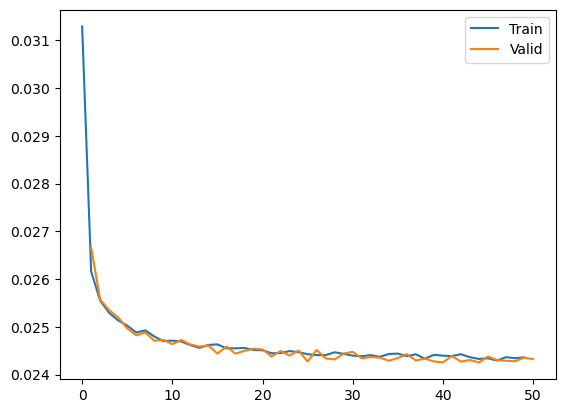

In [24]:
train_metrics = metrics['train']
val_metrics = metrics['valid']
plt.plot(range(len(train_metrics)), train_metrics, label='Train')
plt.plot(range(1, len(val_metrics) + 1), val_metrics, label='Valid')
plt.legend()
plt.show()

In [25]:
pm_model.load_state_dict(best_params)

<All keys matched successfully>

# 5. 제출 파일 작성

## 5.1 test 데이터 불러오기

In [29]:
num_timestamps = 7728
test_aws_data = np.zeros((num_timestamps, 30, 7))
test_pm_data = np.zeros((num_timestamps, 17, 8))
test_aws_data[:, :, :] = np.nan
test_pm_data[:, :, :] = np.nan

aws_meta = pd.read_csv('./META/awsmap.csv')
aws_meta['idx'] = aws_meta['Location'].apply(lambda x : regions_to_id[x])
aws_meta = aws_meta.sort_values(by='idx')
aws_meta = aws_meta.reset_index().drop(['index', 'idx', 'Location', 'Description'], axis=1)

pm_meta = pd.read_csv('./META/pmmap.csv')
pm_meta['Location'] = pm_meta['Location'].apply(lambda x : pm_to_id[x])
pm_meta = pm_meta.sort_values(by=['Location'])
pm_meta = pm_meta.reset_index().drop(['index', 'Location', 'Description'], axis=1)

for i in range(30):
    df = pd.read_csv(f'./TEST_AWS/{id_to_region[i]}.csv')
    lat = aws_meta.iloc[i]['Latitude']
    long = aws_meta.iloc[i]['Longitude']
    for t in range(num_timestamps):
        test_aws_data[t, i, :5] = df.iloc[t, [3, 4, 5, 6, 7]]
        test_aws_data[t, i, -2] = lat_scaler.transform([[lat]])
        test_aws_data[t, i, -1] = lon_scaler.transform([[long]])
        
for i in range(17):
    df = pd.read_csv(f'./TEST_INPUT/{id_to_pm[i]}.csv')
    lat = pm_meta.iloc[i]['Latitude']
    long = pm_meta.iloc[i]['Longitude']
    for t in range(num_timestamps):
        test_pm_data[t, i, 0] = df.iloc[t, 3]
        test_pm_data[t, i, -2] = lat_scaler.transform([[lat]])
        test_pm_data[t, i, -1] = lon_scaler.transform([[long]])

aws_dataset = AWSTrainDataset(data=test_aws_data, num_aws=num_aws, time_size=10)

## 5.2 AWS 데이터 예측

In [38]:
spatial_enc = aws_model.spatial_encoder.to(float)
seq_enc = aws_model.sequential_encoder.to(float)

for i in range(10, num_timestamps):
    if np.isnan(test_aws_data[i]).sum() > 0:
        for aws_idx in range(30):
            inputs = torch.Tensor(aws_dataset.get(i, aws_idx)).double()
            spatial_x = spatial_enc(inputs.unsqueeze(0))
            cnn_out = seq_enc(spatial_x).reshape(1, 1, -1)
            output, _ = aws_model.decoder.lstm(cnn_out.repeat((1,1,2)))
            output = aws_model.decoder.affine(torch.concat([cnn_out, output], dim=2)).flatten()
            if np.isnan(output.detach().numpy()).sum() > 0:
                print(output)
                raise Exception()
            test_aws_data[i, aws_idx, :-2] = output.detach().numpy()
            aws_pos = list(aws_meta.iloc[aws_idx])
            test_aws_data[i, aws_idx, -2:] = aws_pos

## 5.3 PM 데이터 예측

In [44]:
pm_dataset = PMTrainDataset(test_pm_data, num_aws=num_pm, time_size=time_size)

In [47]:
spatial_enc = aws_model.spatial_encoder.to(float)
seq_enc = aws_model.sequential_encoder.to(float)

for i in range(10, test_pm_data.shape[0]):
    if np.isnan(test_pm_data[i]).sum() > 0:
        for pm_idx in range(17):
            pm_pos = list(pm_meta.iloc[pm_idx])
            inputs = torch.Tensor(aws_dataset.get_pm(i, pm_pos)).double()
            spatial_x = spatial_enc(inputs.unsqueeze(0))
            cnn_out = seq_enc(spatial_x).reshape(1, 1, -1)
            output, _ = aws_model.decoder.lstm(cnn_out.repeat((1,1,2)))
            output = aws_model.decoder.affine(torch.concat([cnn_out, output], dim=2)).flatten()
            if np.isnan(output[0].detach()):
                print(output)
                raise Exception()
            test_pm_data[i, pm_idx, 1:-2] = output.detach().numpy()
            test_pm_data[i, pm_idx, -2:] = pm_pos

In [53]:
pm_dataset.data.shape

(7728, 17, 8)

In [55]:
spatial_enc = pm_model.spatial_encoder.to(float)
seq_enc = pm_model.sequential_encoder.to(float)

for i in range(10, test_pm_data.shape[0]):
    if np.isnan(test_pm_data[i]).sum() > 0:
        for pm_idx in range(17):
            inputs = torch.Tensor(pm_dataset.get(i, pm_idx)).double()
            spatial_x = spatial_enc(inputs.unsqueeze(0))
            cnn_out = seq_enc(spatial_x).reshape(1, 1, -1)
            output, _ = pm_model.decoder.lstm(cnn_out.repeat((1,1,2)))
            output = pm_model.decoder.affine(torch.concat([cnn_out, output], dim=2)).flatten()
            if np.isnan(output[0].detach()):
                print(output)
                raise Exception()
            test_pm_data[i, pm_idx, 0] = output.detach().numpy()[0]

## 5.4 제출 파일 작성

In [57]:
test_aws_df = pd.read_csv('./TEST_AWS/공주.csv')
num_timestamps = 7728
timestamp_to_id = {}
for i in range(len(test_aws_df.index)):
    timestamp_to_id[tuple(test_aws_df.loc[i, ['연도', '일시']])] = i

In [59]:
submission_csv = pd.read_csv('./answer_sample.csv')

for i in range(len(submission_csv.index)):
    time = tuple(submission_csv.iloc[i][['연도', '일시']])
    time_idx = timestamp_to_id[time]
    pm_idx = pm_to_id[submission_csv.iloc[i]['측정소']]
    val = test_pm_data[time_idx, pm_idx, 0]
    submission_csv.iloc[i, -1] = val if val > 0 else 0

submission_csv.to_csv('revision1.csv', index=False)